In [1]:
# Loading libraries
from pandas_datareader import DataReader
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
def Kalman_Filter(Y):
 S = Y.shape[0]
 S = S + 1
 "Initialize Params:"
 Z = param0[0]
 T = param0[1]
 H = param0[2]
 Q = param0[3]
 "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 KF_Dens = np.zeros(S)
 for s in range(1,S):
  if s == 1: 
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
  else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]; 
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    KF_Dens[s] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]     
    Likelihood = np.sum(KF_Dens[1:-1])  
    return Likelihood

In [9]:
def Kalman_Smoother(params, Y):
 S = Y.shape[0]
 S = S + 1
 "Initialize Params:"
 Z = params[0]
 T = params[1]
 H = params[2]
 Q = params[3]
 
 "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 for s in range(1,S):
   if s == 1: 
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
   else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]; 
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth = np.zeros(S)
    P_smooth = np.zeros(S)
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
 for  t in range(S-1,0,-1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[t])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
 u_smooth = u_smooth[0:-1]
 return u_smooth

In [48]:
# Ten year data for P&G:
PG = DataReader('PG',  'yahoo', datetime(2009,1,1), datetime(2019,12,31));

# Avergae of opening and closing:
avg = list()
for i in range(len(PG)):
    avg = (PG["Open"] + PG["Close"])/2
PG["Average"] = avg

# Required Dataset: 
PG.head()

,High,Low,Open,Close,Volume,Adj Close,Average
Date,,,,,,,
2009-01-02,62.970001,61.060001,61.689999,62.799999,11135700.0,44.174007,62.244999
2009-01-05,62.439999,61.590000,62.320000,62.349998,14322800.0,43.857475,62.334999
2009-01-06,62.950001,61.509998,62.500000,62.169998,13401600.0,43.730865,62.334999
2009-01-07,61.660000,60.639999,61.330002,61.080002,12415600.0,42.964157,61.205002
2009-01-08,61.250000,60.000000,60.910000,60.410000,11508100.0,42.492859,60.660000


In [49]:
PG.shape

(2768, 7)

Optimization terminated successfully.
         Current function value: -2.403636
         Iterations: 1
         Function evaluations: 18
         Gradient evaluations: 3


C:\Users\sshai\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: OptimizeWarning: Unknown solver options: xtol
  import sys


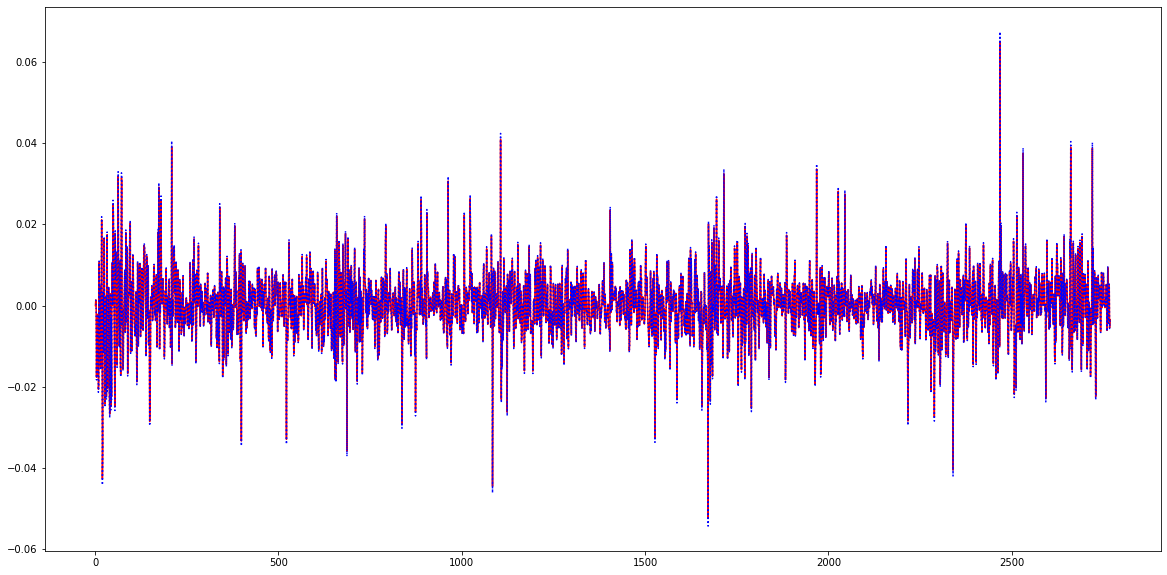

In [68]:
T=PG.shape[0]
PG['log_return'] = np.log(PG['Average'] / PG['Average'].shift(periods=1))
mu = PG['log_return'].mean()
omega = PG['log_return'].var()
Y = PG['log_return']
param0 = np.array([mu, omega, 0.0013, 5])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Y)
timevec = np.linspace(1,T,T)
plt.figure(figsize=(20,10))
plt.plot(timevec, u,'r',timevec, Y,'b:')

In [69]:
Y_dash = np.exp(u) * PG['Average'].shift(periods=1)
mean_error = np.mean(Y_dash - PG['Average'])
rms = sqrt(mean_squared_error(PG['Average'], Y_dash.fillna(0)))
print(rms)

1.1832914614460888
